<a href="https://colab.research.google.com/github/WeronikaRedlinska/ForexForecast/blob/main/BucketLSTMARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Magisterka2025/LSTM

Mounted at /content/drive
/content/drive/MyDrive/Magisterka2025/LSTM


In [2]:
!pip install darts
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

#importing data

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

import os

In [3]:
%cd /content/drive/MyDrive/Magisterka2025/LSTM

/content/drive/MyDrive/Magisterka2025/LSTM


In [4]:
documents = [
    "/content/drive/MyDrive/Magisterka2025/LSTM/data/EURO-PLN_2025-02-10_2025-02-14_1m.csv",
    "/content/drive/MyDrive/Magisterka2025/LSTM/data/EURO-PLN_2025-02-17_2025-02-21_1m.csv",
    "/content/drive/MyDrive/Magisterka2025/LSTM/data/EURO-PLN_2025-02-24_2025-02-28_1m.csv",

]

dataframes = []

for doc in documents:
  df = pd.read_csv(doc)
  df = df.drop([0,1])
  df = df.rename(columns={'Price':'Date'})
  headers = ['Close','High','Low','Open']
  for header in headers:
    df[header]=df[header].astype(float)
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index("Date", inplace= True)
  dataframes.append(df)

dataframes_final = pd.concat(dataframes)
df = dataframes_final
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1min')
df = df.reindex(full_index)
df = df.fillna(method='ffill')
df.head()



<ipython-input-4-6352c1b59b47>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Close,High,Low,Open,Volume
2025-02-10 00:00:00+00:00,4.18839,4.18839,4.18839,4.18839,0
2025-02-10 00:01:00+00:00,4.18839,4.18839,4.18839,4.18839,0
2025-02-10 00:02:00+00:00,4.18930,4.19170,4.18930,4.19170,0
2025-02-10 00:03:00+00:00,4.18930,4.18930,4.18930,4.18930,0
2025-02-10 00:04:00+00:00,4.18930,4.18930,4.18930,4.18930,0


In [5]:
df['prev_close'] = df['Close'].shift(1)
df['Return']=(df['Close']/df['prev_close'] - 1)*100
df = df.iloc[1:]
df = df.loc[:, [ 'Return', 'Close', 'High', 'Low', 'Open', 'Volume', 'prev_close']]
df.head()

,Return,Close,High,Low,Open,Volume,prev_close
2025-02-10 00:01:00+00:00,0.000000,4.18839,4.18839,4.18839,4.18839,0,4.18839
2025-02-10 00:02:00+00:00,0.021733,4.18930,4.19170,4.18930,4.19170,0,4.18839
2025-02-10 00:03:00+00:00,0.000000,4.18930,4.18930,4.18930,4.18930,0,4.18930
2025-02-10 00:04:00+00:00,0.000000,4.18930,4.18930,4.18930,4.18930,0,4.18930
2025-02-10 00:05:00+00:00,0.000000,4.18930,4.18930,4.18930,4.18930,0,4.18930


<Axes: xlabel='time'>

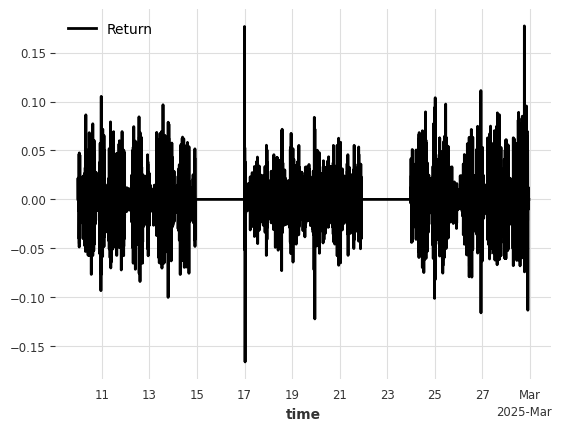

In [6]:
series = TimeSeries.from_dataframe(df, value_cols='Return', freq='1min')
series.plot()

In [7]:
minute_attr = datetime_attribute_timeseries(series.time_index, attribute="minute")


In [8]:
minute_5_bucket = minute_attr.values() // 5
minute_5_series = TimeSeries.from_times_and_values(series.time_index, minute_5_bucket)
print(minute_5_series)

minute_15_bucket = minute_attr.values() // 15
minute_15_series = TimeSeries.from_times_and_values(series.time_index, minute_15_bucket)
print(minute_15_series)

minute_30_bucket = minute_attr.values() // 30
minute_30_series = TimeSeries.from_times_and_values(series.time_index, minute_30_bucket)
print(minute_30_series)

<TimeSeries (DataArray) (time: 27297, component: 1, sample: 1)> Size: 218kB
array([[[ 0.]],

       [[ 0.]],

       [[ 0.]],

       ...,

       [[11.]],

       [[11.]],

       [[11.]]])
Coordinates:
  * time       (time) datetime64[ns] 218kB 2025-02-10T00:01:00 ... 2025-02-28...
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None
<TimeSeries (DataArray) (time: 27297, component: 1, sample: 1)> Size: 218kB
array([[[0.]],

       [[0.]],

       [[0.]],

       ...,

       [[3.]],

       [[3.]],

       [[3.]]])
Coordinates:
  * time       (time) datetime64[ns] 218kB 2025-02-10T00:01:00 ... 2025-02-28...
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None
<TimeSeries (DataArray) (time: 27297, component: 1, sample: 1)> Size: 218kB
array([[

In [9]:
series_15min = series.resample(freq='15min').sum()
series_30min = series.resample(freq='30min').sum()

<Axes: xlabel='time'>

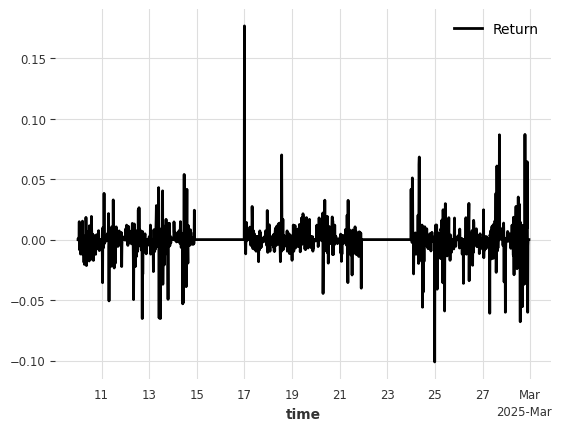

In [10]:
series_15min.plot()

# 1 minute series

In [24]:
#Training, test and validation split (80, 10, 10)
train_size = int(0.8 * len(series))
val_size = int(0.1 * len(series))
test_size = int(0.1 * len(series))

train = series[:train_size]
val = series[train_size:train_size + val_size]
test = series[train_size + val_size:]

In [25]:
train

<TimeSeries (DataArray) (time: 21837, component: 1, sample: 1)> Size: 175kB
array([[[ 0.        ]],

       [[ 0.02173346]],

       [[ 0.        ]],

       ...,

       [[-0.00193365]],

       [[ 0.00386737]],

       [[ 0.00385571]]])
Coordinates:
  * time       (time) datetime64[ns] 175kB 2025-02-10T00:01:00 ... 2025-02-25...
  * component  (component) <U6 24B 'Return'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [12]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [28]:
weekday_series = datetime_attribute_timeseries(series,
                                           attribute = "weekday",
                                            one_hot = True)

minute_series = datetime_attribute_timeseries(
    series,
    attribute="minute",
    one_hot=False
)

minute_series = Scaler().fit_transform(minute_series)



In [29]:
covariates = weekday_series.stack(minute_series)

In [30]:
model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    n_rnn_layers =1,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Forex_LSTM",
    log_tensorboard=True,
    random_state=42,
    training_length=66,
    input_chunk_length=60,
    output_chunk_length = 6,
    force_reset=True,
    save_checkpoints=True,
    # pl_trainer_kwargs = {"accelerator": "gpu",
    #                                  "devices": [0]}
)

In [16]:
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.5 K  | train
6 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.1, training_length=66, batch_size=16, n_epochs=10, optimizer_kwargs={'lr': 0.001}, model_name=Forex_LSTM, log_tensorboard=True, random_state=42, input_chunk_length=60, output_chunk_length=6, force_reset=True, save_checkpoints=True)

In [18]:
pred_series = model.predict(len(test), future_covariates=covariates)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
pred_series
#test.plot()

<TimeSeries (DataArray) (time: 2731, component: 1, sample: 1)> Size: 22kB
array([[[0.4620304 ]],

       [[0.4904549 ]],

       [[0.4874554 ]],

       ...,

       [[0.48439474]],

       [[0.48436498]],

       [[0.51128588]]])
Coordinates:
  * time       (time) datetime64[ns] 22kB 2025-02-25T03:58:00 ... 2025-02-27T...
  * component  (component) object 8B 'Return'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None